In [7]:
import pandas as pd
from pathlib import Path
import pgeon.policy_graph as PG
from example.environment import SelfDrivingEnvironment
from nuscenes import NuScenes
import numpy as np
from matplotlib.patches import Rectangle

from nuscenes.map_expansion.map_api import NuScenesMap, NuScenesMapExplorer
from example.discretizer.discretizer import AVDiscretizer
from example.discretizer.discretizer_d1 import AVDiscretizerD1
import math
from typing import Tuple

from example.dataset.utils import create_rotated_rectangle,determine_travel_alignment
import matplotlib.pyplot as plt

In [8]:
#path where you stored the copy of the nuScenes dataset.
DATAROOT = Path('/home/saramontese/Desktop/MasterThesis/example/dataset/data/sets/nuscenes')


#DATAROOT_pics = Path('/media/saramontese/Riccardo 500GB/NuScenesDataset/data/sets/nuscenes')
#MINI
nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.525 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [9]:

dtype_dict = {
    'modality': 'category',  # for limited set of modalities, 'category' is efficient
    'scene_token': 'str',  
    'timestamp': 'str',  # To enable datetime operations
    'rotation': 'object',  # Quaternion (lists)
    'x': 'float64',
    'y': 'float64',
    'z': 'float64',
    'yaw': 'float64',  
    'velocity': 'float64',
    'acceleration': 'float64',
    'yaw_rate': 'float64'}
df = pd.read_csv(DATAROOT / 'train_v1.0-mini_lidar_0.csv', dtype=dtype_dict, parse_dates=['timestamp'])
#df['detect_CAM_FRONT'] = df['detect_CAM_FRONT'].apply(lambda x: ast.literal_eval(x))
#df['detect_CAM_BACK'] = df['detect_CAM_BACK'].apply(lambda x: ast.literal_eval(x))
city ="boston-seaport"#'singapore-onenorth' #'singapore-hollandvillage' # 'boston-seaport' #'boston-seaport'#'singapore-onenorth' boston-seaport'#
df = df[df['location'] == city]
df.head()

,sample_token,scene_token,steering_angle,location,modality,timestamp,rotation,x,y,z,yaw,velocity,yaw_rate,acceleration
0,cd9964f8c3d34383b16e9c2997de1ed0,2fc3753772e241f2ab2cd16a784cc680,-0.483384,boston-seaport,lidar,2018-08-30 19:25:08.301401,"[-0.13055496249256376, 0.007412290222562217, 0...",334.539851,658.702531,0.0,2.879708,5.125947,-0.056699,0.000000
1,9ab95de13c2d432ebb678ebb5da1ac5e,2fc3753772e241f2ab2cd16a784cc680,-0.392627,boston-seaport,lidar,2018-08-30 19:25:08.801262,"[-0.14457762634660634, 0.007687923603545458, 0...",332.079758,659.418857,0.0,2.851366,5.125947,-0.056699,0.000000
2,4a61e56dd1ee4c159cc595b52aa2a254,2fc3753772e241f2ab2cd16a784cc680,-0.202386,boston-seaport,lidar,2018-08-30 19:25:09.301132,"[-0.1557237496690409, 0.011222825001502285, 0....",329.647494,660.196689,0.0,2.828707,5.108550,-0.045330,-0.034804
3,8c0372d87281421aba897bec0084d0da,2fc3753772e241f2ab2cd16a784cc680,-0.125592,boston-seaport,lidar,2018-08-30 19:25:09.801064,"[-0.16117694469754024, 0.009157178788916257, 0...",327.233834,661.025514,0.0,2.817706,5.104695,-0.022006,-0.007711
4,ebce5a3b3484446580028d6538e69a81,2fc3753772e241f2ab2cd16a784cc680,NaN,boston-seaport,lidar,2018-08-30 19:25:10.200261,"[-0.16222999791894513, 0.010261981974878865, -...",325.362312,661.686833,0.0,2.815673,4.972301,-0.005091,-0.331650


Fit PG

In [4]:
env = SelfDrivingEnvironment(city)
disc = AVDiscretizerD1(env)
pg = PG.PolicyGraph(env, disc)
#pg = pg.fit(df, update=False, verbose=True)

Render

In [10]:
nusc_map = NuScenesMap(dataroot='example/dataset/data/sets/nuscenes', map_name = city)

In [6]:
scene_test = 'c5224b9b454b4ded9b5d2d2634bbda8a' #df['scene_token'].unique()[0] 
example_scene_df = df[df['scene_token']==scene_test]

/home/saramontese/.local/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/saramontese/.local/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


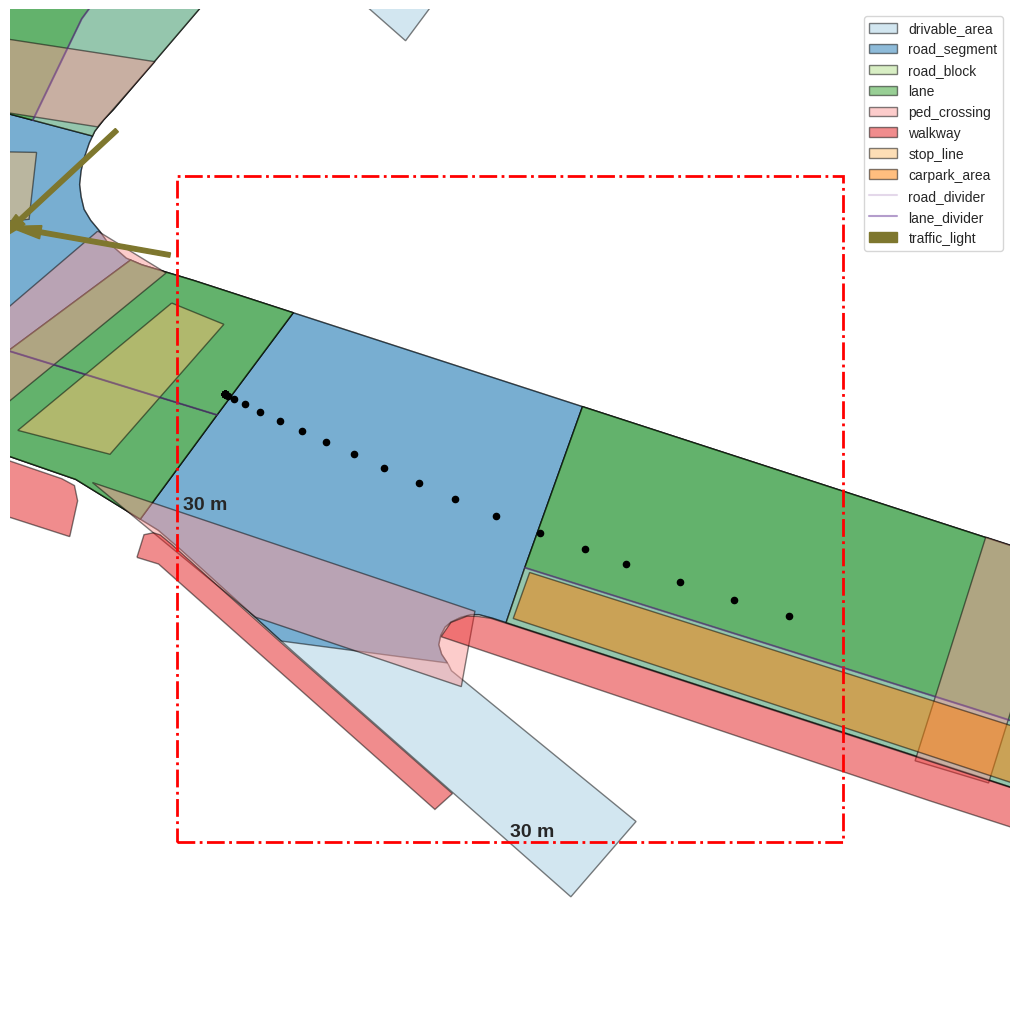

In [13]:

ego_poses = nusc_map.render_egoposes_on_fancy_map(nuscenes, scene_tokens=['2fc3753772e241f2ab2cd16a784cc680'], verbose=False)


## Position Predicates

In [8]:
#nuscenes.render_scene(scene_test)

#### Lane Progress Predicate

In [ ]:
for scene in df['scene_token'].unique():#['295c6c85275e4376bc8446b4a76504cd']:#
    example_scene_df = df[df['scene_token']==scene]
    print(f'SCENE {scene}')
    for i in range(example_scene_df.shape[0]):
        
        x,y,yaw = example_scene_df.iloc[i][['x','y', 'yaw']].tolist()
        
        lane_predicates = env.get_lane_info(x,y, yaw, eps=0.3, agent_size=(2,4))
        print(lane_predicates)
        if False:########
            #PLOT
            ########
            
            #render agent as a renctangle and show its heading direction compare to the direction of the lane
            #for each sample in the scene.
            road_segment_token = nusc_map.record_on_point(x,y, 'road_segment')
            current_lane = nusc_map.record_on_point(x,y, 'lane')

            if road_segment_token and nusc_map.get('road_segment', road_segment_token)['is_intersection'] and not current_lane:
                closest_lane = nusc_map.get_closest_lane(x, y, radius=2)
                lane_path = nusc_map.get_arcline_path(closest_lane)
                closest_pose_idx_to_lane, lane_record, _ = SelfDrivingEnvironment.project_pose_to_lane((x, y, yaw), lane_path)
                if closest_pose_idx_to_lane == len(lane_record) - 1:
                    tangent_vector = lane_record[closest_pose_idx_to_lane] - lane_record[closest_pose_idx_to_lane - 1]
                else:
                    tangent_vector = lane_record[closest_pose_idx_to_lane + 1] - lane_record[closest_pose_idx_to_lane]

            else:

                lane = nusc_map.get_arcline_path(current_lane)
                closest_pose_idx_to_lane, lane_record, distance_along_lane = SelfDrivingEnvironment.project_pose_to_lane((x, y, yaw), lane)
                if closest_pose_idx_to_lane == len(lane_record) - 1:
                        tangent_vector = lane_record[closest_pose_idx_to_lane] - lane_record[closest_pose_idx_to_lane - 1]
                else:
                    tangent_vector = lane_record[closest_pose_idx_to_lane + 1] - lane_record[closest_pose_idx_to_lane]

    
              
            patch_size = 20
            patch_box = [x,y, patch_size, patch_size]
            patch = NuScenesMapExplorer.get_patch_coord(patch_box)
            minx, miny, maxx, maxy = patch.bounds

            fig, ax = nusc_map.render_map_patch( [minx, miny, maxx, maxy], ['road_divider', 'lane_divider'], figsize=(5, 5))
            
            #ax.add_patch(Rectangle((x, y), agent_size[0], agent_size[1], yaw))
            ax.scatter(x,y)
            heading_vector = np.array([np.cos(yaw), np.sin(yaw)])

            yaw =  math.degrees(-(math.pi / 2) + yaw)
            rotated_rectangle = create_rotated_rectangle((x,y), yaw, (2,4))
            ax.quiver(x, y, heading_vector[0], heading_vector[1], color='b', scale=10, label='Ego Direction')
            ax.quiver(x,y, tangent_vector[0], tangent_vector[1],  color='r', scale=10, label='Lane Direction')
            x,y = rotated_rectangle.exterior.xy
            ax.plot(x,y)
            ax.set_title(lane_predicates)
            
    print('-------------------------')

In [ ]:
for i in range(example_scene_df.shape[0]):
    x,y,yaw = example_scene_df.iloc[i][['x','y', 'yaw']].tolist()
    yaw =  math.degrees(-(math.pi / 2) + yaw)
    if True:#is_on_divider(x,y,yaw, (2,4), ['road_divider', 'lane_divider']) in [True]:

         #for visual confirmation
        patch_size = 20
        patch_box = [x,y, patch_size, patch_size]
        patch = NuScenesMapExplorer.get_patch_coord(patch_box)
        minx, miny, maxx, maxy = patch.bounds

        fig, ax = nusc_map.render_map_patch( [minx, miny, maxx, maxy], ['road_divider', 'lane_divider'], figsize=(5, 5))
        
        ax.scatter(x,y)

        rotated_rectangle = create_rotated_rectangle((x,y), yaw, (2,4))
        x,y = rotated_rectangle.exterior.xy
        ax.plot(x,y)
    
        plt.title(f'Plot for index {i}')
        plt.show()


# Proximity Predicates

Geometry

In [20]:
import numpy as np
from shapely.geometry import Point, LineString

def create_semi_circle(center, yaw, radius=8):
    """
    Create a semi-circle as a Shapely Polygon with an option to shift its center in the direction of rotation.

    :param center (tuple): (x, y) coordinates of the semi-circle's center.
    :param yaw (float): Rotation angle in degrees.
    :param radius (float): Radius of the semi-circle.

    :return Polygon: A Shapely Polygon representing the rotated and shifted semi-circle.
    """
    x, y = center

    circle = Point(x, y).buffer(radius)

    yaw_rad = np.radians(yaw)

    direction_vector = np.array([np.cos(yaw_rad), np.sin(yaw_rad)])

    #perpendicular_vector = np.array([direction_vector[0], direction_vector[1]])
    cutting_line = LineString([
        (x - direction_vector[0] * radius, y - direction_vector[1] * radius),
        (x + direction_vector[0] * radius, y + direction_vector[1] * radius)
    ])
    
    split_circle = circle.difference(cutting_line.buffer(0.01))

    return split_circle[1]

Rendering

In [19]:
"""def render_ego_influent_area(x,y,yaw, patch_size=20, non_geometric_layers=['road_divider', 'lane_divider'], agent_size = (15,20)):

        patch_box = [x,y, patch_size, patch_size]
        patch = NuScenesMapExplorer.get_patch_coord(patch_box)
        minx, miny, maxx, maxy = patch.bounds
        
        fig, ax = nusc_map.render_map_patch( [minx, miny, maxx, maxy], non_geometric_layers, figsize=(4, 4), render_egoposes_range=False)
            
        ax.scatter(x,y, color='red')
        yaw =  math.degrees(-(math.pi / 2) + yaw)
        rotated_rectangle = create_rotated_rectangle((x,y), yaw,agent_size, shift_distance=10)
        
        x,y = rotated_rectangle.exterior.xy
        ax.plot(x,y,linewidth=0.4, color='red')
        

        plt.title('Plot for ego vehicle direction')
        plt.show()   """
    
def render_ego_influent_area(x,y,yaw, patch_size=20, non_geometric_layers=['road_divider', 'lane_divider'], shape='rectangle', size = (15,20), shift_distance = 10, radius=8):

        patch_box = [x,y, patch_size, patch_size]
        patch = NuScenesMapExplorer.get_patch_coord(patch_box)
        minx, miny, maxx, maxy = patch.bounds
        
        fig, ax = nusc_map.render_map_patch( [minx, miny, maxx, maxy], non_geometric_layers, figsize=(4, 4), render_egoposes_range=False)
            
        ax.scatter(x,y, color='red')
        yaw_in_deg =  math.degrees(-(math.pi / 2) + yaw)
        
        if shape == 'rectangle':
                front_area = create_rotated_rectangle((x,y), yaw_in_deg,size, shift_distance)
        else:
                front_area = create_semi_circle((x,y), yaw_in_deg, radius)
        x,y = front_area.exterior.xy
        ax.plot(x,y,linewidth=0.4, color='red')

        

        plt.title('Plot for ego vehicle influent area')
        plt.show()   
    


#### Traffic Light Predicate

In [23]:
from shapely.geometry import Point, Polygon

def is_near_traffic_light(yaw, front_area:Polygon, eps=0.5):
        """
        Check if there is a traffic light nearby the given pose (x, y).

        Args:
            x (float): Current x-coordinate of the vehicle.
            y (float): Current y-coordinate of the vehicle.
            yaw (float): Yaw angle of the vehicle in radians.
            front_area (Polygon): area for detecting traffic light.
            eps (float): Epsilon value for alignment tolerance

        Returns:
            bool: True if a traffic light is nearby and aligned with the vehicle's direction of travel, False otherwise.
            (TODO return dict: Information about the nearby traffic light (if any))
        
        """

        # Create a rotated rectangle around the vehicle's current pose
        #yaw_in_deg =  math.degrees(-(math.pi / 2) + yaw)
        #rotated_rectangle = create_rotated_rectangle((x,y), yaw_in_deg, box_size, shift_distance)

        for traffic_light in nusc_map.traffic_light:
                line = nusc_map.extract_line(traffic_light['line_token'])
                xs, ys = line.xy
                point = Point(xs[0], ys[0])# Traffic light is represented as a line, we take the starting point
                
                if point.within(front_area):
                    
                    traffic_light_direction = (xs[1] - xs[0], ys[1] - ys[0])   
                    alignment = determine_travel_alignment(traffic_light_direction, yaw)
                    #print(alignment)
                    if alignment <-eps:
                        return True
                
        return False




#### Stop Sign Predicate

In [13]:
def is_near_stop_sign(x,y, front_area:Polygon):
        """
        Check if there is a stop sign or yield nearby the given pose (x, y).

        Args:
            x (float): Current x-coordinate of the vehicle.
            y (float): Current y-coordinate of the vehicle.
            yaw (float): Yaw angle of the vehicle in radians.

        Returns:
            bool: True if a sign is nearby the ego car and in the same road block, False otherwise.
        
        """        

        current_road_block = nusc_map.record_on_point(x,y, 'road_block')
        #print(f'current road block {current_road_block}')


        for stop_line in nusc_map.stop_line:
            if stop_line['stop_line_type'] in ['STOP_SIGN','YIELD']:
                    stop_line_polygon = nusc_map.extract_polygon(stop_line['polygon_token'])                
                    if stop_line_polygon.intersects(front_area):
                        print(f'a sign is intersecting{stop_line}')

                        if stop_line['road_block_token'] == current_road_block or current_road_block == '': #or intersection
                                return True
                
        return False



#### Pedestrian Crossing Predicate

In [14]:
def is_near_ped_crossing(x,y,front_area:Polygon):
    #render_ego_influent_area(x,y,yaw, patch_size=50, non_geometric_layers=['road_block','road_segment','road_divider', 'lane_divider', 'traffic_light','stop_line','ped_crossing'], agent_size=(15,19))
    
    current_road_block = nusc_map.record_on_point(x,y, 'road_block')
    print(f'current road block {current_road_block}')
    current_road_segment = nusc_map.record_on_point(x,y, 'road_segment')
    print(f'current road segment {current_road_segment}')

        
    for ped_crossing in nusc_map.ped_crossing:  
        ped_crossing_polygon = nusc_map.extract_polygon(ped_crossing['polygon_token'])
        if ped_crossing_polygon.intersects(front_area):
            print('zebra nearby')
            return True

    for stop_line in nusc_map.stop_line:
        if stop_line['stop_line_type'] == 'TURN_STOP':
                stop_line_polygon = nusc_map.extract_polygon(stop_line['polygon_token'])
                if stop_line_polygon.intersects(front_area):
                    print('turn stop')
                    if stop_line['ped_crossing_tokens']:
                        #print(stop_line)
                        #print('turn stop with ped cross')
                            #for token in stop_line['ped_crossing_tokens']:
                                #ped_cross_road_segment = nusc_map.get('ped_crossing', token)['road_segment_token']
                                #print(f'ped_crossing road segment {ped_cross_road_segment}')
                                #if ped_cross_road_segment == current_road_segment: #TODO what if road_segment is none
                                    print('turn stop zebra nearby.')
                                    return True 
                    else:
                        print('turn stop with no ped cross.') #TODO:
        return False

    


In [ ]:
for scene in df['scene_token'].unique():#['295c6c85275e4376bc8446b4a76504cd']:#
    print(f'scene: {scene}')
    example_scene_df = df[df['scene_token']=='ea4c42715ae24b0b952c57a9af1e7731']
    for i in range(30,40):#range(example_scene_df.shape[0]):
        x,y,yaw = example_scene_df.iloc[i][['x','y','yaw']].tolist()
        render_ego_influent_area(x,y,yaw, patch_size=50, non_geometric_layers=['road_block','road_segment','road_divider', 'lane_divider', 'traffic_light','stop_line','ped_crossing'], agent_size=(15,20))

        lane_predicate = is_near_ped_crossing( x,y,yaw)
        traffic_predicate = is_near_traffic_light( x,y,yaw)
        sign_predicate = is_near_stop_sign( x,y,yaw)
        print(f'zebra {lane_predicate}, traffic {traffic_predicate}, stop sign {sign_predicate}')
        
    break

### Test Stop Line Predicate

In [ ]:
from example.discretizer.utils import IsZebraNearby, IsTrafficLightNearby,IsStopSignNearby


In [21]:
def nearby_stop_lines(x,y,yaw, radius = 8):
    
    render_ego_influent_area(x,y,yaw, patch_size=50, non_geometric_layers=['road_block','road_segment','road_divider', 'lane_divider', 'traffic_light','stop_line','ped_crossing'], shape ='circle')

    is_sign_nearby = False#IsStopSignNearby.NO
    is_zebra_nearby = False#IsZebraNearby.NO
    is_traffic_light_nearby = False#IsTrafficLightNearby.NO

    yaw_in_deg =  math.degrees(-(math.pi / 2) + yaw)
    semi_circle = create_semi_circle((x,y), yaw_in_deg, radius)
    #rotated_rectangle = create_rotated_rectangle((x,y), yaw_in_deg, size=(15,19), shift_distance=10)
    
    current_road_block = nusc_map.record_on_point(x,y, 'road_block')
    print(f'current road block {current_road_block}')
    current_road_segment = nusc_map.record_on_point(x,y, 'road_segment')
    print(f'current road segment {current_road_segment}')


    for stop_line in nusc_map.stop_line:
        stop_line_polygon = nusc_map.extract_polygon(stop_line['polygon_token'])
        

        if semi_circle.intersects(stop_line_polygon):
            print(stop_line)
            
            if not is_sign_nearby and stop_line['stop_line_type'] in ['STOP_SIGN','YIELD'] and stop_line['road_block_token'] == current_road_block :
                is_sign_nearby = True#IsStopSignNearby.YES
                for token in stop_line['ped_crossing_tokens']:
                    ped_cross_road_segment = nusc_map.get('ped_crossing', token)['road_segment_token']
                    print(f'ped_crossing road segment {ped_cross_road_segment}')
                    if ped_cross_road_segment == current_road_segment: #NOTE: what is road_segment is none
                        print('zebra nearby. do not know if in my road')
                        is_zebra_nearby = True

                    break
                #render_ego_influent_area(x,y,yaw, patch_size=50, non_geometric_layers=['road_block','road_segment','road_divider', 'lane_divider', 'traffic_light','stop_line','ped_crossing'], agent_size=(15,19))

            if not is_traffic_light_nearby and stop_line['stop_line_type'] == 'TRAFFIC_LIGHT':
                #if stop_line['road_block_token'] == current_road_block or current_road_segment == "": #if same block
                    #render_ego_influent_area(x,y,yaw, patch_size=50, non_geometric_layers=['road_block','road_segment','road_divider', 'lane_divider', 'traffic_light','stop_line','ped_crossing'], agent_size=(15,19))

                    for traffic_light_token in stop_line['traffic_light_tokens']:
                        traffic_light = nusc_map.get('traffic_light', traffic_light_token)
                        line_token = traffic_light['line_token']

                        line = nusc_map.extract_line(line_token)

                        xs, ys = line.xy                 
                                
                        traffic_light_direction = (xs[1] - xs[0], ys[1] - ys[0])
                                
                        alignment = determine_travel_alignment(traffic_light_direction, yaw)
                        eps = 0.5 #explain why not 0.1
                        if alignment <eps:
                            is_traffic_light_nearby = True
                            print(f'traffic light nearby with eps {alignment}')

                            break
                
            if  not is_zebra_nearby and stop_line['stop_line_type'] == 'PED_CROSSING':
                #render_ego_influent_area(x,y,yaw, patch_size=50, non_geometric_layers=['road_block','road_segment','road_divider', 'lane_divider', 'traffic_light','stop_line','ped_crossing'], agent_size=(15,19))

                for token in stop_line['ped_crossing_tokens']:
                    ped_cross_road_segment = nusc_map.get('ped_crossing', token)['road_segment_token']
                    print(f'ped_crossing road segment {ped_cross_road_segment}')
                    if ped_cross_road_segment == current_road_segment: #NOTE: what is road_segment is none
                        print('zebra nearby. do not know if in my road')
                        is_zebra_nearby = True

                    break

            if stop_line['stop_line_type'] == 'TURN_STOP':
                if stop_line['ped_crossing_tokens']:
                    print('turn stop with ped cross')

                    for token in stop_line['ped_crossing_tokens']:
                        ped_cross_road_segment = nusc_map.get('ped_crossing', token)['road_segment_token']
                        print(f'ped_crossing road segment {ped_cross_road_segment}')
                        if ped_cross_road_segment == current_road_segment: #TODO what if road_segment is none
                            print('zebra nearby. do not know if in my road')
                            is_zebra_nearby = True

                        break
                else:

                    #render_ego_influent_area(x,y,yaw, patch_size=50, non_geometric_layers=['road_block','road_segment','road_divider', 'lane_divider', 'traffic_light','stop_line','ped_crossing'], agent_size=(15,19))

                    print('turn stop with no ped cross')
            #    print(f'turn stop info: {stop_line} ')
                

                        
        if is_sign_nearby and  is_zebra_nearby and is_traffic_light_nearby:
           break
        
    return is_sign_nearby, is_zebra_nearby, is_traffic_light_nearby

        


/home/saramontese/.local/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/saramontese/.local/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/tmp/ipykernel_67338/2981419401.py:30: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return split_circle[1]


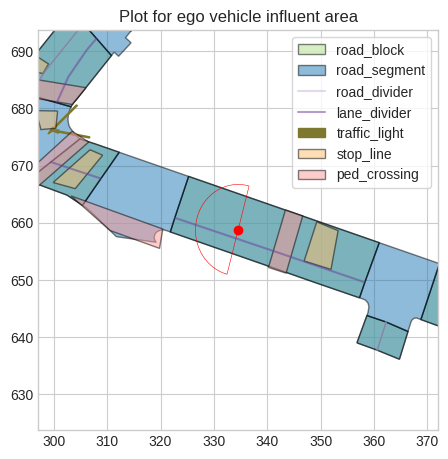

current road block 2992e605-79e2-445f-93eb-c44cb649afb9
current road segment 00d33a52-7718-4204-86ad-08917fd8aaba
(False, False, False)


/home/saramontese/.local/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/saramontese/.local/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/tmp/ipykernel_67338/2981419401.py:30: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return split_circle[1]


KeyboardInterrupt: 

In [22]:
for scene in df['scene_token'].unique():#['295c6c85275e4376bc8446b4a76504cd']:#
    example_scene_df = df[df['scene_token']=='2fc3753772e241f2ab2cd16a784cc680']
    for i in range(0,2):#range(example_scene_df.shape[0]):
        x,y,yaw = example_scene_df.iloc[i][['x','y','yaw']].tolist()
        lane_predicates = nearby_stop_lines( x,y,yaw)
        print(lane_predicates)
        
    break

Road segments are None when we have all lanes of the same direction.
 If we are at intersection or when lanes have opposite direction, road segmenet is not None.